# Kickstarter Projects
## Notebook 03: Data Preparation

Group's members:
- Crnigoj Gabriele 134176
- Ferraro Tommaso 132998
- Stinat Kevin 134905

## Data Loading for Data Predition and Clustering

We load and dump the file with `joblib`. insted of "pickle" because we want to load and dump the data in the right way in order to avoid the possibilities of errors during the reading step.

In [1]:
import numpy as np
import pandas as pd
import joblib
import pickle
import os
from tqdm import tqdm
from tempfile import mkdtemp

In [2]:
savedir = 'Kickstarter_Dataframe'
filename = os.path.join(savedir, 'Kikstarter_Backup_File') 

with open(filename,'rb') as r:
    df_prediction = joblib.load(r)
    
df_prediction.shape

(378661, 22)

## Clustering: Columns Analysis

First we asked ourselves about the titles: in particular we wanted to understand if there was any correlation between the frequency of appearance of the words in the titles and the final state of the project. For this porpouse we used the `nltk` library and the libraries related to it (i.e. `TfidfVectorizer`, `stopwords`, `tokenize and stem`, ...) to analyze the columns of titles in the DataFrame. The results of the analysis is inconclusive: the frequency of appaerance of the words is less than 0.0001% and for this reason, we can't considere that column significative for our analysis. We drop it from the DataFrame that we will use for our next analysis.

```python
import nltk
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
nltk.download('punkt')

stopwords = nltk.corpus.stopwords.words('english') 
stemmer = SnowballStemmer('english')

def tokenize_and_stem(synopsis):
    
    lists_tokenized = []
    
    synopsis = synopsis.lower() #Don't want capital letters
    
    sent_tokens = nltk.sent_tokenize(synopsis) #tokenizes the synopsis into sentences in a list called sent_tokenized
    
    for sentence in sent_tokens:
        list_tokenized = nltk.word_tokenize(sentence) #tokenizes the words in a list called list_tokenized
        lists_tokenized.extend(list_tokenized)
        
    list_stemmed = list(stemmer.stem(i) for i in lists_tokenized) #list with every token stemmed (the root of the word)
    
    only_words = list(filter(lambda x: x.isalpha(), list_stemmed)) #it mantainces only words and nothing else
    
    without_stopwords = list(filter(lambda x: x not in stopwords, only_words)) 
    #if lambda is true, keep the word in the liste, otherwise remove it
    
    return without_stopwords

tfidf_vectorizer_vectors = TfidfVectorizer(max_features = 350, max_df=0.8, min_df=0.0001, analyzer='word', tokenizer = tokenize_and_stem)

tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(df['name'])
tfidf_vectorizer_vectors

```

## Data Preparation and Cleaning for Prediction#

First we changed the name of some columns for greater convenience. Furthermore, we faced with a huge limitation: the computation times and the memory occupied during clustering and prediction operations. For this reason we were forced to find a sub DataFrame that it was possibile to manage with our computers. But we don't select a random portion of the DatFrame with the function `.sample()`, we clean the inconcistent parte of our DataFrame comparing the columns and the rows with the previous analysis in the Notebook_02.

First we delete the columns `'deadline'`, `'launched'`, `'name'`, `'ID'`, `'Launch_Day'`, `'Deadline_Day'`, `'goal'`, `'pledged'`, `'usd pledged'`, because they are repetited in other columns or are meaningless for our analysis.

Furthermore, we deleted from the DataFrame the rows and consequently the columns of the projects that are not started in the country `US` and the projects that haven't the `USD` currency. The explanation of our behaviour can be found in the Notebook_02: the projects with the most percentage to be successful and numerous number of project belong to the two categories expressed above.

The same reason is behind our choice to focus only `'Product Design'`, `'Documentary'`, `'Music'`, `'Tabletop Games'`, `'Shorts'`, `'Food'`, `'Film & Video'`: those categories have more change to be successful than the other that are excluded by our analysis.

We also concentrate our analysis on the states `'failed'`, `'successful'`, `'canceled'` because they are the most meaningful, indeed we do not consider the rows with `NaN` or/and `Null` values.

In [3]:
#Let's drop and rename the columns which are useless for our analysis
df_prediction.rename(columns = {'MDeadline_Month':'Deadline_Month', 'crowdfounding_period':'period_days'}, inplace = True)
df_prediction = df_prediction.drop(columns = ['deadline', 'launched', 'name', 'ID', 'Launch_Day', 'Deadline_Day'])

In [4]:
df_prediction.drop(df_prediction[df_prediction.currency != 'USD'].index, inplace=True)
df_prediction.drop(df_prediction[df_prediction.country != 'US'].index, inplace=True)
df_prediction = df_prediction.drop(columns=['goal', 'pledged', 'country', 'usd pledged', 'currency'])

In [5]:
main_category = ['Product Design', 'Documentary', 'Music', 'Tabletop Games', 'Shorts', 'Food', 'Film & Video']
other_states = ['failed', 'successful', 'canceled']

df = pd.DataFrame(columns = df_prediction.columns)
df_ks = pd.DataFrame(columns = df.columns)

for i in tqdm(main_category):
    temp = df_prediction
    temp = temp.drop(temp[temp.category != i ].index)
    df = df.append(temp)

for i in tqdm(other_states):
    temp = df
    temp = temp.drop(temp[temp.state != i ].index)
    df_ks  = df_ks.append(temp)

100%|██████████| 3/3 [00:00<00:00,  4.23it/s]


In [6]:
df_ks.shape

(79476, 11)

In [7]:
df_ks.nunique()

category                7
main_category           5
state                   3
backers              2601
usd_pledged_real    26380
usd_goal_real        2910
Launch_Year            10
Launch_Month           12
Deadline_Year          10
Deadline_Month         12
period_days            95
dtype: int64

In [8]:
filename = os.path.join(savedir, 'Kikstarter_Backup_File_Prova_Predizione')

with open(filename,'wb') as r:
    joblib.dump(df_ks , r)

## Data Preparation and Cleaning for Clustering

In first place we encode categorical features as a one-hot numeric array. `OneHotEncoder` is a function in which the input to this transformer should be an array-like of integers or strings, denoting the values taken on by categorical (discrete) features. With this funciont This creates a binary column for each category and returns a sparse matrix or dense array (depending on the sparse parameter) By default, the encoder derives the categories based on the unique values in each feature. Alternatively, you can also specify the categories manually. This encoding is needed for feeding categorical data to the analisys of `Clustering` because it needs only Ordinal values.

We also normalized our data with the Function `.StandardScaler()` because our data aren't only binary and we need to normalized them to avoid that some values would have greater weight than others.

For the second part od our analysis, we use `Principal Component Analysis (PCA)`, that is a linear dimensionality reduction technique that can be utilized for extracting information from a high-dimensional space by projecting it into a lower-dimensional sub-space. It tries to preserve the essential parts that have more variation of the data and remove the non-essential parts with fewer variation. One important thing to note about PCA is that it is an Unsupervised dimensionality reduction technique, you can cluster the similar data points based on the feature correlation between them without any supervision (or labels)

Why does we apply `PCA`? For Data Visualization: When working on any data related problem, the challenge in today's world is the sheer volume of data, and the variables/features that define that data. To solve a problem where data is the key, you need extensive data exploration like finding out how the variables are correlated or understanding the distribution of a few variables. Considering that there are a large number of variables or dimensions along which the data is distributed, visualization can be a challenge and almost impossible. Our main porpouse was to find how much columns of our DataFrame can be deleted to streamline it.

In [9]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [10]:
#change the type af the last date columns
df_ks = df_ks.fillna(0)

OneHotEncoder_obj = OneHotEncoder(sparse = False)
df_OneHotEncoder = pd.DataFrame(OneHotEncoder_obj.fit_transform(df_ks[['category', 'main_category', 'state']]))
df_OneHotEncoder.shape

(79476, 15)

In [11]:
categories_list = []

for i in OneHotEncoder_obj.categories_:
    for k in i:
        categories_list.append(k)

df_OneHotEncoder.columns = categories_list

In [12]:
#create a new dataframe more suitable for our analysis
df_ks = df_ks.drop(columns=['category', 'main_category', 'state'])
df_ks = df_ks.reset_index()
df_ks = df_ks.drop(columns=['index'])
df_concat = pd.concat([df_ks, df_OneHotEncoder], axis = 1)

#and normalized it
x = StandardScaler().fit_transform(df_concat)
x_normalized = pd.DataFrame(x)
x_normalized.columns = df_concat.columns
x_normalized.head()

,backers,usd_pledged_real,usd_goal_real,Launch_Year,Launch_Month,Deadline_Year,Deadline_Month,period_days,Documentary,Film & Video,...,Shorts,Tabletop Games,Design,Film & Video,Food,Games,Music,canceled,failed,successful
0,-0.121874,-0.098294,-0.041742,1.191785,1.094765,1.176878,1.299302,-0.060753,-0.45491,-0.331359,...,-0.386322,-0.39245,1.995231,-0.816938,-0.370722,-0.39245,-0.411291,-0.329039,1.050946,-0.863489
1,-0.076002,-0.079780,0.106267,-0.762258,0.792978,-0.809679,0.996768,-0.006175,-0.45491,-0.331359,...,-0.386322,-0.39245,1.995231,-0.816938,-0.370722,-0.39245,-0.411291,-0.329039,1.050946,-0.863489
2,-0.124786,-0.099306,-0.031043,0.703275,-1.319529,0.680239,-0.818436,0.266720,-0.45491,-0.331359,...,-0.386322,-0.39245,1.995231,-0.816938,-0.370722,-0.39245,-0.411291,-0.329039,1.050946,-0.863489
3,-0.117505,-0.094087,-0.030448,0.703275,0.491191,0.680239,0.694234,-0.060753,-0.45491,-0.331359,...,-0.386322,-0.39245,1.995231,-0.816938,-0.370722,-0.39245,-0.411291,-0.329039,1.050946,-0.863489
4,-0.124786,-0.099306,-0.032826,0.703275,-1.017743,0.680239,-0.818436,-0.060753,-0.45491,-0.331359,...,-0.386322,-0.39245,1.995231,-0.816938,-0.370722,-0.39245,-0.411291,-0.329039,1.050946,-0.863489


In [13]:
pca = PCA()

principalComponents = pca.fit(x_normalized)
principalComponents

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

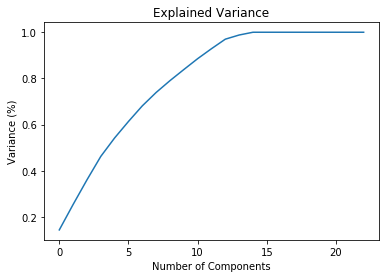

In [14]:
plt.figure()
plt.plot(np.cumsum(principalComponents.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

In [15]:
filename = os.path.join(savedir, 'Kikstarter_Backup_File_Prova')

with open(filename,'wb') as r:
    joblib.dump(x_normalized , r)

## Conclusion of Notebook 03
> As we can see from the `Explained Variance` graph above, the number of columns that `PCA` and the number of columns that we have decided to choose are more or less the same. For this reason, we decided to procede to dump the new DataFrame the we have obtained for the next analysis.